In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from scipy.optimize import minimize
from keras import regularizers
import scipy
import math
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import ParameterGrid


In [2]:
dataTT = loadmat(f"Data04-08_TT_UltVag_Cut.mat")
dataTF = loadmat(f"Data04-08_TF_UltVag_Cut.mat")

dataBaseline = dataTT['Baseline']
dataCincoP = dataTT['CincoP']
dataDez = dataTT['DezP']

dataBaseline = pd.DataFrame(dataBaseline)

dataCincoP = pd.DataFrame(dataCincoP)

dataDez = pd.DataFrame(dataDez)

In [3]:
def normalize_dataframe(dataframe):
    min_val = tf.reduce_min(dataframe)
    max_val = tf.reduce_max(dataframe)
    
    normalized_dataframe = (dataframe.values - min_val) / (max_val - min_val)
    normalized_dataframe = tf.cast(normalized_dataframe, tf.float32)
    return normalized_dataframe

# Normalize dataframes outside the loop
dataBaseline_normalized = pd.DataFrame(normalize_dataframe(dataBaseline))
dataBaseline_normalized_test = dataBaseline_normalized.sample(200)
dataBaseline_train = dataBaseline_normalized.drop(dataBaseline_normalized_test.index)

dataCincoP_normalized = pd.DataFrame(normalize_dataframe(dataCincoP))
dataDez_normalized = pd.DataFrame(normalize_dataframe(dataDez))

2024-04-15 22:06:51.676827: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-15 22:06:51.676848: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-15 22:06:51.676852: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-15 22:06:51.676881: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 22:06:51.676898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def run_autoencoder(dataBaseline_train, x_test_Baseline, epochs, patience, batch_size):
    num_terms = dataBaseline_train.columns.shape[0]
    input_layer = Input(shape=(num_terms,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    encoded = layers.Dense(16, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    
    decoded = layers.Dense(16, activation='relu')(encoded)
    decoded = layers.Dense(32, activation='relu')(decoded)
    decoded = layers.Dense(64, activation='relu')(decoded)
    decoded = layers.Dense(num_terms, activation='linear')(decoded)

    autoencoder = keras.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mae')

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, metrics=['accuracy']) 

    autoencoder.fit(dataBaseline_train, dataBaseline_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[callback],
                    validation_data=(x_test_Baseline, x_test_Baseline),
                    verbose=0)
    
    return autoencoder

def optimize_hyperparameters(dataBaseline_train, x_test_Baseline, num_runs=5):
    # Define a grade de parâmetros a serem testados
    param_grid = {
        'epochs': [500, 1000, 1500],
        'patience': [100, 200, 300],
        'batch_size': [20, 40, 60]
    }
    
    best_loss = float('inf')
    best_params = None

    # Realiza a busca em grade com validação cruzada
    for params in ParameterGrid(param_grid):
        total_loss = 0.0
        for _ in range(num_runs):
            autoencoder = run_autoencoder(dataBaseline_train, x_test_Baseline, **params)
            total_loss += autoencoder.history.history['loss'][-1] # Apenas a perda final

        avg_loss = total_loss / num_runs

        # Atualiza os melhores parâmetros, se necessário
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = params

    return best_params, best_loss

# best_params, best_loss = optimize_hyperparameters(dataBaseline_train, x_test_Baseline)

# print("Melhores Hiperparâmetros:")
# print(best_params)
# print("Menor Loss Médio Encontrado:", best_loss)

In [5]:
def run_autoencoder(x, y):
    num_terms = x.columns.shape[0]
    input_layer = Input(shape=(num_terms,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    encoded = layers.Dense(16, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)

    decoded = layers.Dense(16, activation='relu')(encoded)
    decoded = layers.Dense(32, activation='relu')(decoded)
    decoded = layers.Dense(64, activation='relu')(decoded)
    decoded = layers.Dense(num_terms, activation='sigmoid')(decoded)

    autoencoder = keras.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mae')

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100) 

    autoencoder.fit(x, x,
                    epochs=100,
                    batch_size=40,
                    shuffle=True,
                    callbacks=[callback],
                    validation_data=(y, y),
                    verbose=1)
    
    return autoencoder

In [7]:
# plt.plot(autoencoder.history.history["loss"])
# plt.title("Train loss")
# plt.grid()
# plt.xlabel("Iteration")
# plt.ylabel("Loss")

1/1 [==============================] - 0s 29ms/step


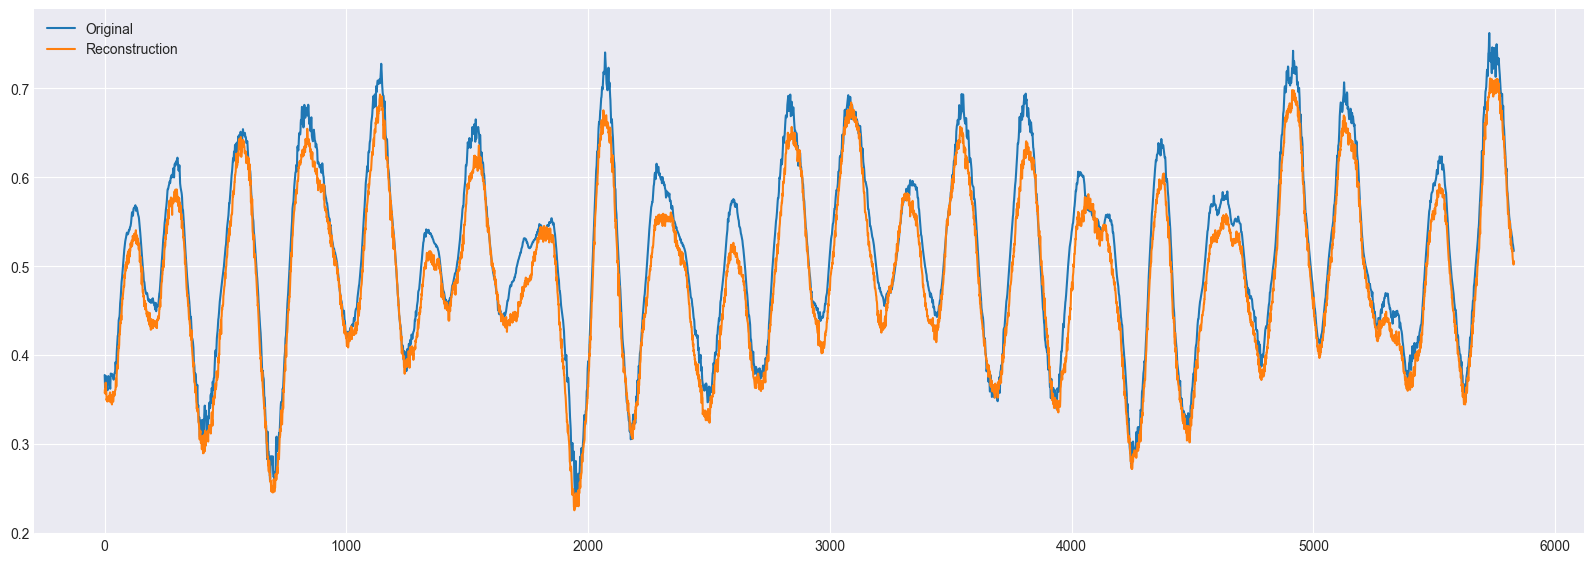

In [41]:
num_terms = dataCincoP.shape[1]
x = np.arange(0, num_terms)
decoded_results = autoencoder.predict(dataDez_normalized.iloc[[125]])  # Predicting for the first row

plt.figure(figsize=(20, 15))

# Display original
plt.subplot(2, 1, 1)
plt.plot(x, dataDez_normalized.iloc[125].values, label="Original")
plt.plot(x, decoded_results[0], label="Reconstruction")

plt.legend()
plt.show()

In [9]:
def mahalanobis_cenario(conjuntos_de_dados):

    num_conjuntos = 16  # 16 conjuntos de 50 termos. Ou seja: 800 dados
    num_dados = 50
    rodagens_autoencoder = 3
    Mahalanobis_dict = {'dataBaseline': [], 'dataCincoP': [], 'dataDez': []}
    Mahalanobis_dict_mean = {'dataBaseline': [], 'dataCincoP': [], 'dataDez': []}

    for i in range(rodagens_autoencoder):
        # Exemplo de uso:
        dataBaseline_normalized_iter = dataBaseline_normalized 
        keras.backend.clear_session()

        autoencoder = run_autoencoder(dataBaseline_normalized, dataBaseline_normalized_test)

        for cenario, data_cenario in conjuntos_de_dados.items():

            dataBaseline_normalized_iter = dataBaseline_normalized 
            data_cenario_iter = data_cenario

            for _ in range(num_conjuntos):

                dados_baseline_atual = dataBaseline_normalized_iter.sample(num_dados) 
                dataBaseline_normalized_iter = dataBaseline_normalized_iter.drop(dados_baseline_atual.index)
                dado_analisado_atual = data_cenario_iter.sample(num_dados)
                data_cenario_iter = data_cenario_iter.drop(dado_analisado_atual.index)

                # Cálculo do MAE para o conjunto de dados baseline
                y_1 = np.array(dados_baseline_atual)
                reconstructions = autoencoder.predict(y_1)
                test_loss_baseline = tf.keras.losses.mae(reconstructions, y_1)

                
                y_2 = np.array(dado_analisado_atual)
                reconstructions = autoencoder.predict(y_2)
                test_loss_cenario_analisado = tf.keras.losses.mae(reconstructions, dado_analisado_atual)

                epsilon = 0.001  # Valor de regularização
                # Calculando a distância de Mahalanobis 
                V = np.cov(np.array([test_loss_cenario_analisado, test_loss_baseline]).T)  # Matriz de covariância
                V += epsilon * np.eye(V.shape[0])  # Adicionando ruído diagonal
                IV = np.linalg.inv(V)  # Inversa da matriz de covariância

                mahalanobis_distance = mahalanobis(test_loss_cenario_analisado, test_loss_baseline, IV)  # Distância de Mahalanobis

                Mahalanobis_dict[cenario].append(mahalanobis_distance)

            Mahalanobis_dict_mean[f"{cenario}"] = np.array(Mahalanobis_dict[f"{cenario}"]).mean()
        del autoencoder

    return Mahalanobis_dict, Mahalanobis_dict_mean

# Chamar a função mahalanobis        

conjuntos_de_dados = {'dataBaseline': dataBaseline_normalized, 'dataCincoP': dataCincoP_normalized, 'dataDez': dataDez_normalized}
resultados_mahalanobis = mahalanobis_cenario(conjuntos_de_dados)


Epoch 1/100
25/25 [==============================] - 1s 12ms/step - loss: 0.0816 - val_loss: 0.0597
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0592 - val_loss: 0.0602
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0597 - val_loss: 0.0602
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0595 - val_loss: 0.0600
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0600 - val_loss: 0.0612
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0598 - val_loss: 0.0601
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0599 - val_loss: 0.0606
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0594 - val_loss: 0.0596
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0595 - val_loss: 0.0602
Epoch 10/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0604 - val_loss: 0.0607
Epoch 11

Distância média para Baseline de dano:  1.390507817697969
Distância média para Cinco de dano:  1.4048163830228124
Distância média para Dez de dano:  1.406726308945134


/var/folders/rf/1_hnp3pn4yv55169p6hq1qdr0000gn/T/ipykernel_8192/3406281837.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Estilo do gráfico


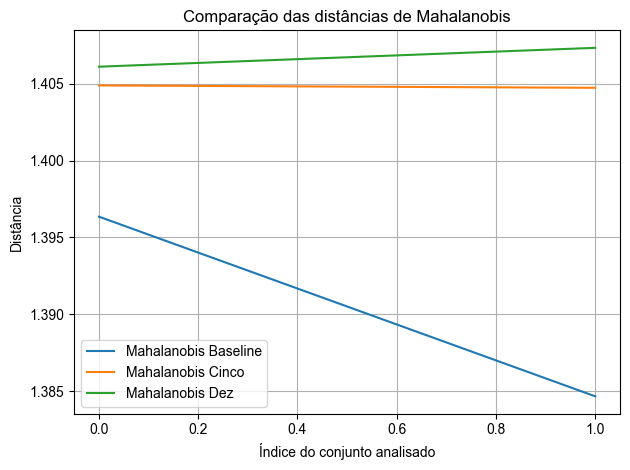

In [10]:
x = np.arange(0, len(resultados_mahalanobis[0]["dataCincoP"]))  # Chaves em minúsculas

# Média distâncias
print("Distância média para Baseline de dano: ", np.array(resultados_mahalanobis[1]["dataBaseline"]).mean())  # Chaves em minúsculas
print("Distância média para Cinco de dano: ", np.array(resultados_mahalanobis[1]["dataCincoP"]).mean())  # Chaves em minúsculas
print("Distância média para Dez de dano: ", np.array(resultados_mahalanobis[1]["dataDez"]).mean())     # Chaves em minúsculas

# Plotagens
plt.plot(x, resultados_mahalanobis[0]["dataBaseline"], label='Mahalanobis Baseline')  # Chaves em minúsculas
plt.plot(x, resultados_mahalanobis[0]["dataCincoP"], label='Mahalanobis Cinco')  # Chaves em minúsculas
plt.plot(x, resultados_mahalanobis[0]["dataDez"], label='Mahalanobis Dez')       # Chaves em minúsculas

# Legendas
plt.legend()

# Título e rótulos dos eixos
plt.title('Comparação das distâncias de Mahalanobis')
plt.xlabel('Índice do conjunto analisado')
plt.ylabel('Distância')

# Adiciona grade
plt.grid(True)

# Ajustes estéticos opcionais
plt.style.use('seaborn-darkgrid')  # Estilo do gráfico
plt.tight_layout()  # Ajusta o layout para evitar cortes

# Exibição do gráfico
plt.show()

In [11]:
resultados_mahalanobis

({'dataBaseline': [1.2713714049491922,
   1.321065899078957,
   1.2697185018603077,
   1.3020387155983526],
  'dataCincoP': [1.3711000957308475,
   1.3620611010303008,
   1.367724882586832,
   1.363094678001899],
  'dataDez': [1.3802444349165028,
   1.381663681523894,
   1.3784894675069412,
   1.3811104311371045],
  'dataVinte': [1.2898597905687064,
   1.3256260724844515,
   1.3233563472370486,
   1.3237607810252794]},
 {'dataBaseline': 1.2910486303717024,
  'dataCincoP': 1.3659951893374698,
  'dataDez': 1.3803770037711107,
  'dataVinte': 1.3156507478288715})

In [12]:
def data_split(data, p=0.1):
    if np.isscalar(p) and p >= 1.0:
        return data
    
    n_data = data.shape[0]
    idx = np.arange(n_data)
    np.random.shuffle(idx)
    
    idx = idx[:int(n_data * p)]
    return data.iloc[idx, :]

In [13]:
Teste_Caso = ["x_test_Baseline_splitted", "x_test_Cinco_splitted", "x_test_Dez_splitted", "x_test_Vinte_splitted"]
legenda = ['Baseline', 'DC1=5%', 'DC2=10%', 'DC3=20%'] 
cor = ['forestgreen', 'orange', 'royalblue', 'firebrick', 'magenta']

In [14]:
ntestes = 4 # Quantas variáveis de dano são adicionadas
n_it = 40 #Numero de conjuntos
n_vbatch = 5 #Numero de rodadas do AE - variabilidade do processador
n_passagens = 50  #Numero de passagens para cada ponto da curva ROC/cada conjunto
n_passag = '50'

n_pass_base = n_passagens/800
n_pass_dano = n_passagens/1000
    
Media = np.zeros((ntestes, n_it, n_vbatch))
Desvio = np.zeros((ntestes, n_it, n_vbatch))
Mediana = np.zeros((ntestes, n_it, n_vbatch))
DKL = np.zeros((ntestes, n_it, n_vbatch))
DI = np.zeros((ntestes, n_it, n_vbatch))

for n in range(n_vbatch):  
        
        autoencoder = run_autoencoder(dataBaseline, x_test_Baseline)

        reconstructions_train = autoencoder.predict(dataBaseline)
        train_loss = tf.keras.losses.mae(reconstructions_train, dataBaseline)

        #Ajuste de uma distribuição normal para Y=ln(train_loss)
        train_norm_log = np.log(train_loss)
        normFittolog_train = scipy.stats.norm.fit(train_norm_log)
        
        MediaTrain = normFittolog_train[0]
        DesvioTrain = normFittolog_train[1]

        min_val = tf.reduce_min(dataBaseline)
        max_val = tf.reduce_max(dataBaseline)

        for iter in range(n_it):
          print('Iteração: ', iter)
          for t in range(ntestes):

            x_test_Baseline_splitted = data_split(x_test_Baseline, p=n_pass_base)
            x_test_Cinco_splitted = data_split(x_test_Cinco, p=n_pass_dano)
            x_test_Dez_splitted = data_split(x_test_Dez, p=n_pass_dano)
            x_test_Vinte_splitted = data_split(x_test_Vinte, p=n_pass_dano)


            Teste = eval(Teste_Caso[t])
            Teste = Teste.values
            teste_data = (Teste - min_val) / (max_val - min_val)
            teste_data = tf.cast(teste_data, tf.float32)
          
            #Crie um gráfico semelhante, desta vez para o teste com dano
            reconstructions = autoencoder.predict(teste_data)
            test_loss = tf.keras.losses.mae(reconstructions, teste_data)
            
            test_norm_log = np.log(test_loss)
            normFittolog_test = scipy.stats.norm.fit(test_norm_log)
            
            
            #Media[t, iter, n] = MediaTestNC/fc   #Media do teste corrigido pelo fc
            Media[t, iter, n] = normFittolog_test[0]
            Desvio[t, iter, n] = normFittolog_test[1]
            Mediana[t, iter, n] = np.median(test_loss)
            
            DKL[t, iter, n] = np.log(Desvio[t, iter, n]/DesvioTrain)+((1/(2*(Desvio[t, iter, n]**2)))*((DesvioTrain**2)+(Media[t, iter, n]-MediaTrain)**2))-(1/2)      
            DI[t, iter, n] = np.log(DKL[t, iter, n]+math.exp(1))-1

Epoch 1/500
32/32 [==============================] - 1s 11ms/step - loss: 0.2255 - val_loss: 0.4594
Epoch 2/500
32/32 [==============================] - 0s 7ms/step - loss: 0.1087 - val_loss: 0.4344
Epoch 3/500
32/32 [==============================] - 0s 7ms/step - loss: 0.1045 - val_loss: 0.4295
Epoch 4/500
32/32 [==============================] - 0s 7ms/step - loss: 0.1038 - val_loss: 0.4348
Epoch 5/500
32/32 [==============================] - 0s 7ms/step - loss: 0.1036 - val_loss: 0.4271
Epoch 6/500
32/32 [==============================] - 0s 7ms/step - loss: 0.1030 - val_loss: 0.4265
Epoch 7/500
32/32 [==============================] - 0s 7ms/step - loss: 0.1023 - val_loss: 0.4188
Epoch 8/500
32/32 [==============================] - 0s 7ms/step - loss: 0.1015 - val_loss: 0.4171
Epoch 9/500
32/32 [==============================] - 0s 7ms/step - loss: 0.1003 - val_loss: 0.4053
Epoch 10/500
32/32 [==============================] - 0s 7ms/step - loss: 0.0989 - val_loss: 0.3840
Epoch 11

NameError: name 'x_test_Cinco' is not defined

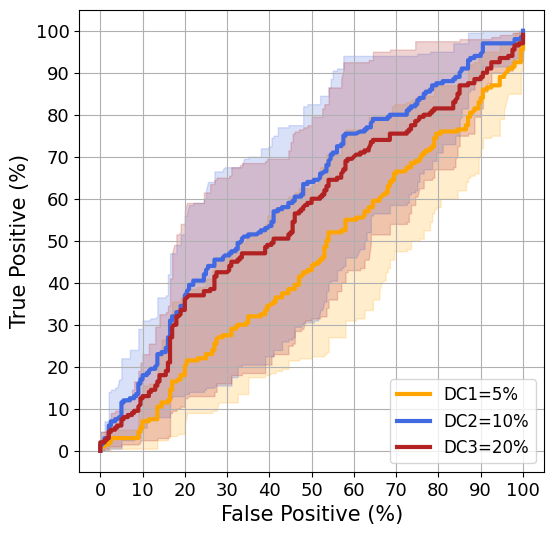

In [ ]:
## ROC based KLD
# Calculate (P || q)
n_thresholds = 5000

metrica = DI  # Media, Desvio, Mediana ou DI
metric = 'DKL'

verdadeiros_negativos = np.zeros((3, n_thresholds, n_vbatch))  # 5%, 10%, and 20%
verdadeiros_positivos = np.zeros((3, n_thresholds, n_vbatch))
falsos_negativos = np.zeros((3, n_thresholds, n_vbatch))
falsos_positivos = np.zeros((3, n_thresholds, n_vbatch))

tpr = np.zeros((3, n_thresholds, n_vbatch))
fpr = np.zeros((3, n_thresholds, n_vbatch))

# Plots

for nvar in range(n_vbatch):
    sem_dano = metrica[0, :, nvar]

    min_threshold = metrica[:, :, nvar].min()
    max_threshold = metrica[:, :, nvar].max()

    for caso in range(metrica.shape[0] - 1):  # Cenarios de 5%, 10% e 20%
        com_dano = metrica[caso + 1, :, nvar]

        thresholds = np.linspace(min_threshold, max_threshold, n_thresholds)
        for idx, threshold in enumerate(thresholds):
            verdadeiros_negativos[caso, idx, nvar] = np.sum(sem_dano <= threshold)
            verdadeiros_positivos[caso, idx, nvar] = np.sum(com_dano > threshold)
            falsos_negativos[caso, idx, nvar] = np.sum(com_dano <= threshold)
            falsos_positivos[caso, idx, nvar] = np.sum(sem_dano > threshold)

            tpr[caso, idx, nvar] = verdadeiros_positivos[caso, idx, nvar] / (
            verdadeiros_positivos[caso, idx, nvar] + falsos_negativos[caso, idx, nvar])
            fpr[caso, idx, nvar] = falsos_positivos[caso, idx, nvar] / (
            falsos_positivos[caso, idx, nvar] + verdadeiros_negativos[caso, idx, nvar])

tprMean = np.zeros((3, n_thresholds))
fprMean = np.zeros((3, n_thresholds))

fig, ax2 = plt.subplots()

# Obtem a media e desvio das taxas de VPs e FPs para cada cenario e threshold
for caso in range(metrica.shape[0] - 1):
    for idx in range(n_thresholds):
        # tpr e fpr
        tprMean[caso, idx] = np.mean(tpr[caso, idx, :])
        fprMean[caso, idx] = np.mean(fpr[caso, idx, :])

    # Calcula os percentis 2.5 e 97.5 para criar a faixa de confiança
    percentile_2_5 = np.percentile(tpr[caso, :, :], 5, axis=1) * 100
    percentile_97_5 = np.percentile(tpr[caso, :, :], 95, axis=1) * 100

    ax2.plot(fprMean[caso, :] * 100, tprMean[caso, :] * 100, linewidth=3.0, color=cor[caso + 1],
             label=f'{legenda[caso + 1]}')
    ax2.fill_between(fprMean[caso, :] * 100, percentile_2_5, percentile_97_5, color=cor[caso + 1], alpha=0.2)

ax2.legend(loc='lower right', numpoints=1, fontsize=12)
plt.xlabel('False Positive (%)', fontsize=15)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=13)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=13)
plt.ylabel('True Positive (%)', fontsize=15)
plt.grid(True)
fig.set_size_inches(6, 6)
plt.show()


1/1 [==============================] - 0s 10ms/step


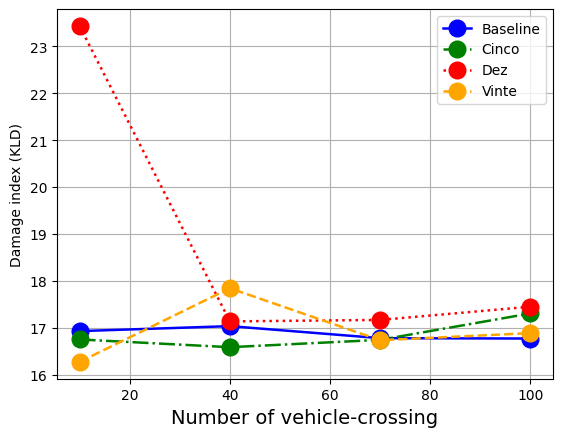

In [ ]:
def plot_KLD(ncenarios):
    Caso = ["x_test_Baseline_splitted", "x_test_Cinco_splitted", "x_test_Dez_splitted", "x_test_Vinte_splitted"]

    n_teste = 0.2  # Treinado com 100 dados de aceleração do baseline (testado 80%)

    # Divide os dados baseline em dois conjuntos - para treinamento e validacao
    baseline_train, baseline_valid = train_test_split(
        dataBaseline_train, test_size=n_teste, random_state=42
    )

    linha = ['solid', 'dashdot', 'dotted', 'dashed']

    n_it = 1  # Numero de amostras

    n_vbatch = 4  # Conjuntos de passagens de veículos analisados (50 a 400 de 50 em 50)

    n_pass_base = np.linspace((0.01 / n_teste), (0.1 / n_teste), num=n_vbatch)
    n_pass_dano = np.linspace(0.01, 0.1, num=n_vbatch)

    Teste = np.zeros((ncenarios, x_test_Baseline.shape[0], x_test_Baseline.shape[1], n_it, n_vbatch))
    Media = np.zeros((ncenarios, n_it, n_vbatch))
    Desvio = np.zeros((ncenarios, n_it, n_vbatch))

    MediaTrain = np.zeros((n_it))
    DesvioTrain = np.zeros((n_it))
    MedianaTrain = np.zeros((n_it))

    autoencoder = run_autoencoder(baseline_train, baseline_valid)

    min_val = tf.reduce_min(baseline_train)
    max_val = tf.reduce_max(baseline_train)

    for n in range(n_vbatch):
        p_base = n_pass_base[n]
        p_dano = n_pass_dano[n]

        for iter in range(n_it):
            reconstructions_train = autoencoder.predict(baseline_train)
            train_loss = tf.keras.losses.mae(reconstructions_train, baseline_train)

            train_norm_log = np.log(train_loss)
            normFittolog_train = scipy.stats.norm.fit(train_norm_log)

            MediaTrain[iter] = normFittolog_train[0]
            DesvioTrain[iter] = normFittolog_train[1]

            for t in range(ncenarios):
                x_test_Baseline_splitted = data_split(x_test_Baseline, p=p_base).values
                x_test_Cinco_splitted = data_split(x_test_Cinco, p=p_dano).values
                x_test_Dez_splitted = data_split(x_test_Dez, p=p_dano).values
                x_test_Vinte_splitted = data_split(x_test_Vinte, p=p_dano).values

                Teste_atual = eval(Caso[t])

                teste_data = (Teste_atual - min_val) / (max_val - min_val)
                teste_data = tf.cast(teste_data, tf.float32)

                reconstructions = autoencoder.predict(teste_data)
                test_loss = tf.keras.losses.mae(reconstructions, teste_data)

                test_norm_log = np.log(test_loss)
                normFittolog_test = scipy.stats.norm.fit(test_norm_log)

                Media[t, iter, n] = normFittolog_test[0]
                Desvio[t, iter, n] = normFittolog_test[1]

    n_vbatch = len(Media[0, 0, :])  # Numero de conjunto de passagens analizadas
    ncenarios = len(Media[:, 0, 0])  # Numero de cenarios analisados

    DI = np.zeros((ncenarios, n_vbatch))
    na = 0  # numero da amostra (só uma amostra de 400 dados)

    for nc in range(ncenarios):
        for nb in range(n_vbatch):
            DKL = np.log(Desvio[nc, na, nb] / DesvioTrain) + (
                        (1 / (2 * (Desvio[nc, na, nb] ** 2))) * (
                            (DesvioTrain ** 2) + (Media[nc, na, nb] - MediaTrain) ** 2)) - (1 / 2)
            DI[nc, nb] = np.log(DKL + math.exp(1)) - 1

    DamageIndex = DI

    xmin = n_pass_base[0] * x_test_Baseline.shape[0]
    xmax = n_pass_base[-1:] * x_test_Baseline.shape[0]
    x = np.linspace(xmin, xmax, n_vbatch)

    cor = ['blue', 'green', 'red', 'orange']
    legenda = ['Baseline', 'Cinco', 'Dez', 'Vinte']

    for i in range(ncenarios):
        plt.plot(x, DamageIndex[i, :], linestyle=linha[i], linewidth=1.8, marker="o", markersize=12, color=cor[i],
                 markerfacecolor=cor[i], label=legenda[i])

    #xticks = np.linspace(0, 100, 10, endpoint=True)
    #yticks = np.linspace(0, 1.2, num=7, endpoint=True)
    plt.xlabel('Number of vehicle-crossing', fontsize=14)
    #plt.xticks(xticks, fontsize=12)
    #plt.yticks(yticks, fontsize=12)
    plt.ylabel('Damage index (KLD)')
    plt.legend(loc='best')
    plt.grid(True)
    #plt.tight_layout()

    return Media, Desvio


fig, ax = plt.subplots()
Media, Desvio = plot_KLD(ncenarios=4)   
